In [1]:
from pyspark.sql import SparkSession

path_to_jar = "/home/jovyan/work/data/jars/postgresql-42.3.2.jar"

spark = SparkSession.builder.master("local") \
    .appName("Analysis") \
    .config("spark.jars", path_to_jar) \
    .getOrCreate()

sc = spark.sparkContext

1. Reading data from Postgres

In [2]:
df_stats = (
    spark.read
    .format("jdbc")
    .option("url", "jdbc:postgresql://postgres:5432/nba")
    .option("dbtable", "public.players_stats")
    .option("user", "nba")
    .option("password", "nba")
    .option("driver", "org.postgresql.Driver")
    .load()
)
df_stats.limit(10).toPandas().head(5)

,RK,Name,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER,flag
0,1,Joel Embiid PHI,C,51,33.099998,29.5,9.3,19.000000,49.000000,1.3,...,82.199997,11.2,4.4,1.1,1.4,3.0,31,2,31.420000,Season_Regular_2021_22
1,2,Giannis Antetokounmpo MIL,PF,53,32.799999,29.4,10.0,18.500000,54.299999,1.1,...,72.400002,11.6,6.0,1.0,1.4,3.3,35,4,32.160000,Season_Regular_2021_22
2,3,LeBron James LAL,SF,46,36.799999,29.4,11.1,21.200001,52.200001,2.8,...,76.400002,8.1,6.2,1.5,1.0,3.4,18,4,26.510000,Season_Regular_2021_22
3,4,DeMar DeRozan CHI,SF,60,35.900002,28.1,10.3,20.200001,51.200001,0.7,...,86.599998,5.3,5.1,0.9,0.3,2.4,5,0,24.340000,Season_Regular_2021_22
4,5,Trae Young ATL,PG,58,34.599998,28.0,9.4,20.500000,45.700001,2.9,...,89.699997,3.8,9.3,0.9,0.1,4.0,31,0,25.280001,Season_Regular_2021_22


## 2. Select last 3 season data



In [3]:
from pyspark.sql.functions import col

seasons = ["Season_Regular_2021_22",
           "Season_Regular_2020_21", 
           "Season_Regular_2019_20", 
           "Season_Regular_2018_19", 
           "Season_Regular_2017_18",
           "Season_Regular_2016_17"
          ]
df_stats_last_three = df_stats.where(col('flag').isin(seasons)).toPandas()

df_stats_last_three["Name"] = df_stats_last_three["Name"].str.split(" ").str[:-1]
df_stats_last_three["Name"] = df_stats_last_three["Name"].str.join(" ")
df_stats_last_three['POS'] = df_stats_last_three['POS'].map({'PG': 1, 'SG': 2, 'SF': 3, 'PF': 4, 'C': 5, 'G': 6, 'F': 7})
df_stats_last_three = df_stats_last_three.groupby(by='Name').mean().round(2)
df_stats_last_three = df_stats_last_three.reset_index(drop=False)

# reject players with less than 400 min in season
df_stats_last_three = df_stats_last_three[(df_stats_last_three['GP']*df_stats_last_three['MIN']) > 400]

df_stats_last_three.head(5)

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FTA,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER
1,Aaron Brooks,395.00,6.0,48.50,9.85,3.65,1.40,3.40,40.450001,0.50,...,0.45,76.349998,0.80,1.25,0.30,0.05,0.65,0.00,0.00,9.74
2,Aaron Gordon,85.67,4.0,64.33,31.18,14.60,5.50,12.07,45.900002,1.37,...,3.20,70.099998,6.58,2.88,0.78,0.63,1.70,11.67,0.33,15.22
4,Aaron Holiday,244.50,1.0,57.50,17.92,7.25,2.68,6.42,41.950001,0.95,...,1.12,82.599998,1.68,2.30,0.62,0.22,1.05,1.00,0.00,11.29
6,Aaron Nesmith,382.00,3.0,46.00,14.50,4.70,1.70,3.90,43.799999,0.90,...,0.60,78.599998,2.80,0.50,0.30,0.20,0.50,0.00,0.00,9.46
7,Abdel Nader,352.50,3.0,47.00,13.22,5.00,1.78,4.05,42.950001,0.68,...,1.02,71.750000,1.95,0.58,0.35,0.30,0.68,0.00,0.00,9.69


In [4]:
drop = ["RK", "Name", "POS", "GP", "MIN","TO","PER"]
stats_train = df_stats_last_three.drop(columns=drop)
stats_train.head()

,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,REB,AST,STL,BLK,DD2,TD3
1,3.65,1.40,3.40,40.450001,0.50,1.50,36.500000,0.40,0.45,76.349998,0.80,1.25,0.30,0.05,0.00,0.00
2,14.60,5.50,12.07,45.900002,1.37,4.07,32.430000,2.23,3.20,70.099998,6.58,2.88,0.78,0.63,11.67,0.33
4,7.25,2.68,6.42,41.950001,0.95,2.55,37.150002,0.90,1.12,82.599998,1.68,2.30,0.62,0.22,1.00,0.00
6,4.70,1.70,3.90,43.799999,0.90,2.30,37.000000,0.50,0.60,78.599998,2.80,0.50,0.30,0.20,0.00,0.00
7,5.00,1.78,4.05,42.950001,0.68,1.78,36.700001,0.75,1.02,71.750000,1.95,0.58,0.35,0.30,0.00,0.00


In [5]:
#skalowanie danych
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
stats_scaled=pd.DataFrame(scaler.fit_transform(stats_train))
stats_scaled.columns=stats_train.columns
stats_scaled.round(3).head(5)

,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,REB,AST,STL,BLK,DD2,TD3
0,0.056,0.065,0.093,0.282,0.107,0.133,0.806,0.041,0.026,0.722,0.015,0.103,0.109,0.021,0.000,0.000
1,0.455,0.505,0.554,0.406,0.294,0.362,0.716,0.257,0.310,0.648,0.461,0.279,0.370,0.260,0.237,0.013
2,0.187,0.202,0.254,0.316,0.204,0.227,0.821,0.100,0.095,0.795,0.083,0.216,0.283,0.091,0.020,0.000
3,0.095,0.097,0.120,0.358,0.193,0.205,0.817,0.053,0.041,0.748,0.169,0.022,0.109,0.083,0.000,0.000
4,0.106,0.105,0.128,0.339,0.146,0.158,0.811,0.083,0.085,0.668,0.104,0.030,0.136,0.124,0.000,0.000


In [6]:
from sklearn.decomposition import PCA
n_components=stats_train.shape[1]
pca = PCA(n_components=n_components, random_state=123)
pca.fit(stats_scaled)

PCA(n_components=16, random_state=123)

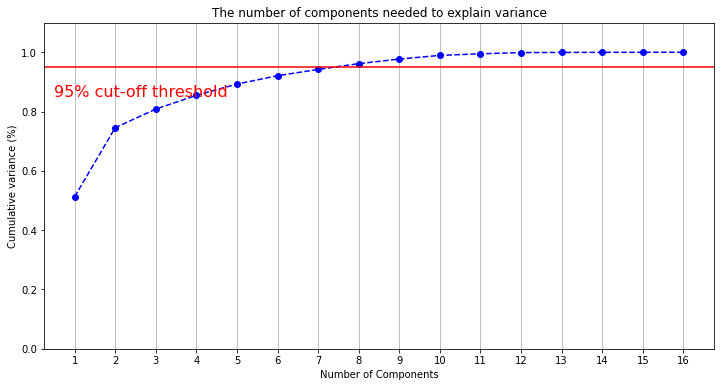

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 17, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 17, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [8]:
import numpy as np

explained_variance_ratio = pca.explained_variance_ratio_ 
cum_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

cum_explained_variance_ratio

lst = []
for i in range (0, n_components):
    lst.append([i+1, round(explained_variance_ratio[i],6), cum_explained_variance_ratio[i]])

pca_predictor = pd.DataFrame(lst)
pca_predictor.columns = ['Component', 'Explained Variance', 'Cumulative Explained Variance']
pca_predictor

,Component,Explained Variance,Cumulative Explained Variance
0,1,0.512917,0.512917
1,2,0.232780,0.745697
2,3,0.062832,0.808529
3,4,0.046266,0.854795
4,5,0.038076,0.892871
5,6,0.028104,0.920975
6,7,0.021218,0.942193
7,8,0.019533,0.961726
8,9,0.015526,0.977251
9,10,0.012221,0.989473


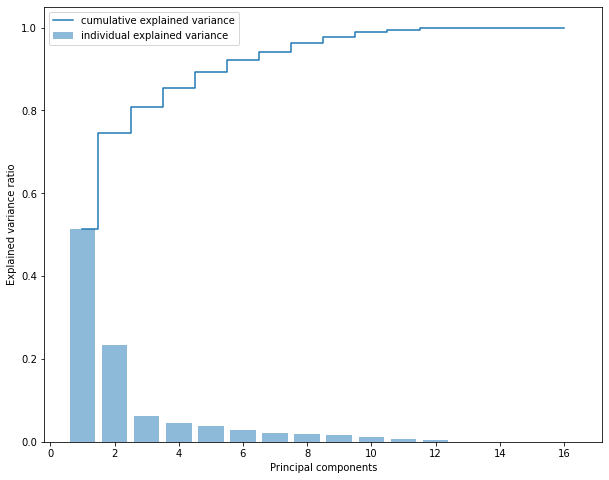

In [9]:
plt.subplots(figsize=(10,8))

plt.bar(pca_predictor['Component'],pca_predictor['Explained Variance'], align='center', alpha=0.5, 
       label='individual explained variance')
plt.step(pca_predictor['Component'],pca_predictor['Cumulative Explained Variance'], where='mid',
         label='cumulative explained variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio');
plt.legend(loc='best')

In [10]:
n_components = 7
pca = PCA(n_components)
dim_reduction = pca.fit_transform(stats_scaled)
reduced_df = df_stats_last_three.copy()
for i in range(n_components):
    reduced_df[f'PCA{i+1}'] = [dim_reduction[x][i] for x in range(len(dim_reduction))]

reduced_df.head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,DD2,TD3,PER,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7
1,Aaron Brooks,395.00,6.0,48.50,9.85,3.65,1.40,3.40,40.450001,0.50,...,0.00,0.00,9.74,-0.531466,-0.255569,0.000379,-0.009000,-0.177395,0.018422,0.004912
2,Aaron Gordon,85.67,4.0,64.33,31.18,14.60,5.50,12.07,45.900002,1.37,...,11.67,0.33,15.22,0.470477,0.130112,-0.092967,0.021170,0.012594,0.088283,-0.011170
4,Aaron Holiday,244.50,1.0,57.50,17.92,7.25,2.68,6.42,41.950001,0.95,...,1.00,0.00,11.29,-0.171647,-0.242894,0.041093,0.023361,-0.090050,-0.040586,-0.009229
6,Aaron Nesmith,382.00,3.0,46.00,14.50,4.70,1.70,3.90,43.799999,0.90,...,0.00,0.00,9.46,-0.433517,-0.198849,-0.153901,0.016742,-0.094366,0.022009,-0.029419
7,Abdel Nader,352.50,3.0,47.00,13.22,5.00,1.78,4.05,42.950001,0.68,...,0.00,0.00,9.69,-0.432218,-0.160023,-0.109390,0.023656,-0.110707,-0.010735,0.045243


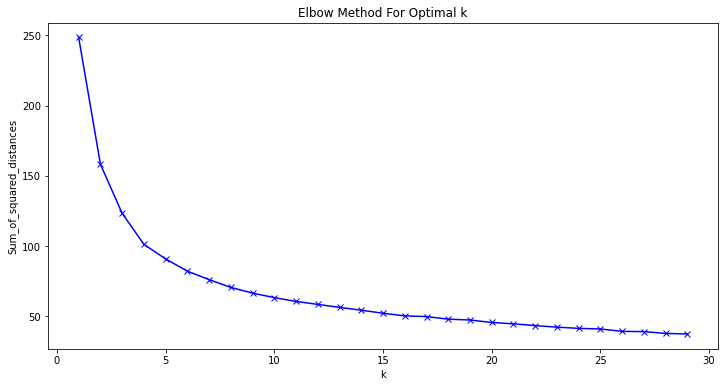

In [11]:
from sklearn.cluster import KMeans

sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dim_reduction)
    sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [12]:
num_clusters = 6
kmeans = KMeans(num_clusters, init="k-means++", random_state=42)
clusters = kmeans.fit_predict(dim_reduction)

reduced_df['Cluster'] = clusters
reduced_df = reduced_df.reset_index(drop=True)

In [13]:
reduced_df.head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,TD3,PER,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,Cluster
0,Aaron Brooks,395.00,6.0,48.50,9.85,3.65,1.40,3.40,40.450001,0.50,...,0.00,9.74,-0.531466,-0.255569,0.000379,-0.009000,-0.177395,0.018422,0.004912,5
1,Aaron Gordon,85.67,4.0,64.33,31.18,14.60,5.50,12.07,45.900002,1.37,...,0.33,15.22,0.470477,0.130112,-0.092967,0.021170,0.012594,0.088283,-0.011170,2
2,Aaron Holiday,244.50,1.0,57.50,17.92,7.25,2.68,6.42,41.950001,0.95,...,0.00,11.29,-0.171647,-0.242894,0.041093,0.023361,-0.090050,-0.040586,-0.009229,1
3,Aaron Nesmith,382.00,3.0,46.00,14.50,4.70,1.70,3.90,43.799999,0.90,...,0.00,9.46,-0.433517,-0.198849,-0.153901,0.016742,-0.094366,0.022009,-0.029419,5
4,Abdel Nader,352.50,3.0,47.00,13.22,5.00,1.78,4.05,42.950001,0.68,...,0.00,9.69,-0.432218,-0.160023,-0.109390,0.023656,-0.110707,-0.010735,0.045243,5


In [14]:
cluster_labels = kmeans.labels_
reduced_df['Cluster'] = cluster_labels

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


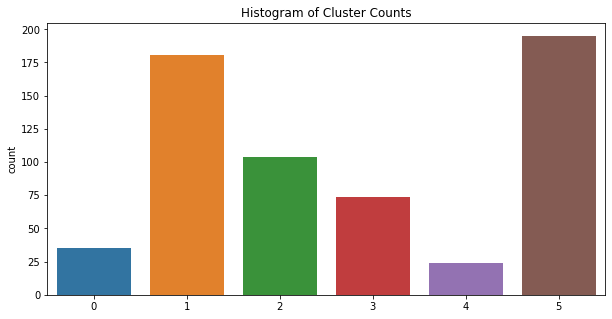

In [15]:
import seaborn as sns

ax=plt.subplots(figsize=(10,5))
ax=sns.countplot(cluster_labels)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [16]:
averages_df = reduced_df.groupby('Cluster').mean()
averages_df = averages_df.reset_index(drop=False)
averages_df = averages_df.apply(lambda x: round(x, 3))

In [17]:
df = averages_df[['PTS','FGM','FGA','FG%','3PM','3PA', '3P%', 'FTM','FTA','FT%','REB','AST','STL','BLK','DD2','TD3']]
df

,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,REB,AST,STL,BLK,DD2,TD3
0,23.299999,8.252,17.357,47.591999,1.974,5.437,35.212002,4.834,5.963,81.200996,6.788,5.614,1.224,0.699,20.136,2.591
1,8.998000,3.304,7.602,43.382000,1.201,3.343,34.923000,1.191,1.532,77.177002,3.386,2.163,0.743,0.355,1.738,0.029
2,14.822000,5.393,12.214,44.062000,1.736,4.819,35.476002,2.298,2.849,80.134003,4.521,3.374,0.920,0.428,4.732,0.280
3,6.329000,2.603,4.700,55.875000,0.074,0.274,11.597000,1.042,1.549,67.324997,4.808,1.018,0.472,0.673,3.913,0.019
4,13.685000,5.474,9.890,56.166000,0.310,0.954,20.875000,2.433,3.579,68.629997,9.139,2.003,0.727,1.192,23.862,0.539
5,5.394000,1.992,4.651,42.514000,0.669,1.983,32.386002,0.746,1.002,73.389999,2.491,1.300,0.481,0.257,0.486,0.001


Text(0, 0.5, 'value')

<Figure size 2400x720 with 0 Axes>

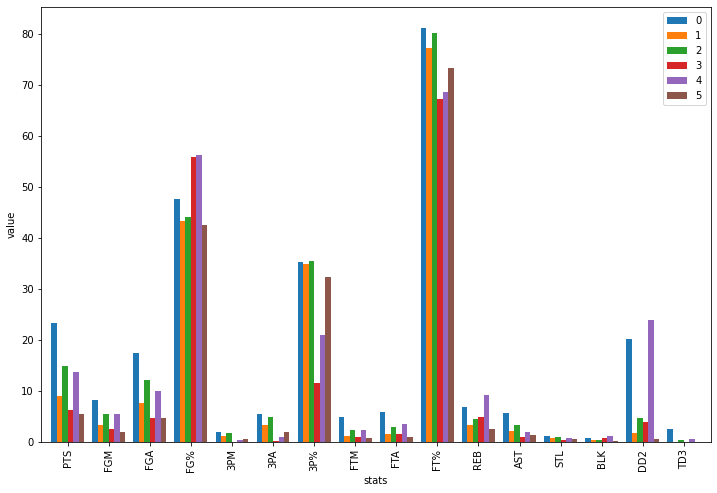

In [18]:
df_transpsed = df.transpose()

plt.figure(figsize=(20, 6), dpi=120)
df_transpsed.plot(kind="bar", figsize=(12,8), width=0.8)
# plt.title("Mince Pie Consumption Study")
plt.xlabel("stats")
plt.ylabel("value")

# Cluster 0:
    - Sperhero  - PSA, FGM - dużo zbobytych punktów, w tym z gry, wybloków, gracze biorący ciężary gry, TD3

# Cluster 1:
    - Assistant, Robin, all in 1 - dużo punktów i asyst ale nie tyle co gracze w 1 klastrze, gracze również aktywni


 # Cluster 2:
 Wingers - także sporo punktów, bardzo duży procent punktów za 3, sporo asyst

# Cluster 3:
    - player - uzupełnienie składu, duży odestek punktów z gry w stosunku do innych sugeruje że są to też gracze jednowymiarowy

# Cluster 4:
    Giants - dużo punktów, wybloków, zbiórek, najwięcej DD2 typowy taran podkoszowy


# Cluster 5:
   - outsider - gracz rezerwowy - niskie statystki sugerujące sporadyczną grę ale też niższe umiejętności niż gracze z pozosłych klastrów

In [19]:
reduced_df.drop(columns=['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7'], inplace=True)

In [20]:
reduced_df[reduced_df['Cluster'] == 0].sort_values("PER",ascending=False).head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER,Cluster
201,Giannis Antetokounmpo,6.83,4.0,67.33,33.549999,27.42,9.88,17.980000,54.880001,0.92,...,71.680000,11.25,5.60,1.27,1.40,3.33,43.33,4.00,29.629999,0
449,Nikola Jokic,29.67,5.0,71.50,31.879999,21.17,8.13,15.020000,54.150002,1.17,...,83.129997,10.93,6.92,1.22,0.72,3.02,47.67,12.17,27.610001,0
26,Anthony Davis,11.60,4.0,60.80,34.439999,25.98,9.50,18.559999,51.000000,0.80,...,80.160004,10.42,2.92,1.44,2.22,2.24,35.40,0.20,27.309999,0
254,James Harden,7.17,2.0,65.17,36.430000,29.57,8.75,19.700001,44.430000,3.55,...,86.370003,7.08,9.35,1.60,0.70,4.70,35.83,9.83,27.280001,0
286,Joel Embiid,12.17,5.0,51.83,30.520000,25.27,8.25,16.930000,48.549999,1.15,...,80.730003,10.97,3.20,0.87,1.72,3.37,34.00,0.67,26.809999,0


In [21]:
reduced_df[reduced_df['Cluster'] == 1].sort_values("PER",ascending=False).head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER,Cluster
83,Chris Boucher,238.25,4.0,52.75,15.850000,8.10,2.85,5.88,47.520000,0.80,...,80.150002,4.78,0.48,0.45,1.20,0.55,6.00,0.00,20.709999,1
471,Pau Gasol,227.00,4.0,57.00,20.299999,8.80,3.27,6.87,46.900002,0.57,...,72.099998,6.80,2.37,0.30,0.87,1.07,9.33,0.33,18.629999,1
439,Naz Reid,162.00,5.0,66.00,17.549999,9.70,3.65,7.25,50.549999,0.80,...,71.949997,4.15,0.95,0.45,1.05,1.00,1.50,0.00,17.730000,1
553,Thomas Bryant,214.50,5.0,35.75,19.400000,9.88,4.00,6.65,55.650002,0.58,...,68.620003,5.18,1.25,0.32,0.72,0.80,6.50,0.00,17.700001,1
250,Jamal Crawford,201.50,6.0,56.75,17.980000,8.88,3.25,7.68,43.119999,1.17,...,65.120003,1.02,2.88,0.42,0.12,1.08,0.00,0.00,17.540001,1


In [22]:
reduced_df[reduced_df['Cluster'] == 2].sort_values("PER",ascending=False).head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER,Cluster
417,Michael Porter Jr.,117.50,3.0,58.00,23.850000,14.150000,5.40,10.200000,52.549999,1.95,...,81.199997,6.00,0.95,0.60,0.70,1.10,12.00,0.00,20.240000,2
340,Kevin Love,69.33,4.0,46.17,27.570000,16.219999,5.20,12.230000,42.450001,2.42,...,86.400002,9.27,2.28,0.57,0.27,1.78,20.33,0.00,19.490000,2
375,Lou Williams,60.80,2.0,73.20,26.860001,17.920000,5.84,13.720000,42.340000,1.70,...,87.279999,2.64,4.54,0.86,0.16,2.36,3.60,0.20,18.889999,2
419,Mike Conley,59.67,1.0,50.83,30.750000,17.150000,5.70,13.350000,42.720001,2.28,...,83.550003,3.17,5.42,1.18,0.25,1.88,4.33,0.00,18.530001,2
67,CJ McCollum,23.17,2.0,65.50,35.119999,22.070000,8.48,18.549999,45.750000,2.75,...,81.169998,4.05,3.98,0.92,0.47,1.80,1.83,0.17,18.360001,2


In [23]:
reduced_df[reduced_df['Cluster'] == 3].sort_values("PER",ascending=False).head()


,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER,Cluster
492,Robert Williams III,285.25,5.0,41.25,17.780001,6.42,2.82,3.92,72.000000,0.00,...,64.570000,5.90,1.22,0.70,1.62,0.78,6.50,0.25,22.400000,3
105,Daniel Gafford,217.00,5.0,53.50,17.600000,8.00,3.40,4.95,68.349998,0.00,...,69.300003,5.10,0.75,0.45,1.45,0.85,4.00,0.00,21.860001,3
239,JaVale McGee,239.17,5.0,64.67,14.750000,7.72,3.35,5.48,61.430000,0.02,...,64.320000,5.17,0.55,0.38,1.25,0.97,4.17,0.00,21.660000,3
54,Brandon Clarke,140.67,4.0,55.67,21.870001,10.90,4.60,7.87,59.330002,0.27,...,69.699997,5.63,1.47,0.73,0.90,0.67,2.67,0.00,20.950001,3
429,Mitchell Robinson,205.00,5.0,53.75,24.180000,8.42,3.62,5.10,71.500000,0.00,...,54.150002,7.55,0.53,0.88,1.88,0.68,9.50,0.00,20.900000,3


In [24]:
reduced_df[reduced_df['Cluster'] == 4].sort_values("PER",ascending=False).head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER,Cluster
503,Rudy Gobert,80.00,5.0,67.50,32.549999,14.77,5.47,8.13,67.220001,0.00,...,65.099998,13.03,1.43,0.72,2.35,1.78,48.67,0.00,23.230000,4
175,Enes Freedom,126.20,5.0,68.00,22.580000,12.28,5.04,8.84,57.240002,0.04,...,78.040001,9.18,1.26,0.46,0.56,1.46,26.40,0.00,23.020000,4
213,Hassan Whiteside,120.67,5.0,59.33,24.120001,12.57,5.27,9.12,58.200001,0.02,...,60.599998,10.68,0.78,0.50,1.90,1.47,31.17,0.00,22.860001,4
433,Montrezl Harrell,104.33,5.0,67.17,22.820000,13.82,5.58,9.00,62.320000,0.02,...,66.169998,5.73,1.50,0.57,0.87,1.20,7.83,0.00,22.850000,4
88,Clint Capela,92.83,5.0,60.50,29.299999,13.82,6.07,9.60,62.650002,0.00,...,54.980000,11.97,1.10,0.70,1.63,1.25,33.83,0.17,22.620001,4


In [25]:
reduced_df[reduced_df['Cluster'] == 5].sort_values("PER",ascending=False).head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER,Cluster
53,Brandon Bass,300.00,4.0,52.00,11.10,5.60,2.10,3.60,57.500000,0.0,...,87.500000,2.50,0.40,0.30,0.20,0.60,0.00,0.0,19.709999,5
119,David West,304.50,7.0,70.50,13.15,5.70,2.50,4.45,55.349998,0.0,...,76.349998,3.15,2.05,0.60,0.85,1.15,0.00,0.0,18.790001,5
603,Willie Reed,338.50,5.0,56.50,12.35,4.95,2.10,3.45,61.849998,0.0,...,56.950001,3.80,0.30,0.25,0.60,0.45,2.50,0.0,18.170000,5
106,Daniel Theis,261.75,5.0,64.75,19.33,7.45,2.95,5.38,54.919998,0.5,...,73.150002,4.95,1.32,0.50,0.90,0.80,4.00,0.0,16.540001,5
161,Drew Eubanks,349.67,4.0,43.33,10.63,4.23,1.57,2.80,56.669998,0.0,...,77.199997,3.43,0.70,0.23,0.57,0.70,1.67,0.0,16.459999,5


## Redukcja do 3 komponentów - wizualizacja

In [26]:
n_components = 3
pca = PCA(n_components)
dim_reduction = pca.fit_transform(stats_scaled)
reduced_df = df_stats_last_three.copy()
for i in range(n_components):
    reduced_df[f'PCA{i+1}'] = [dim_reduction[x][i] for x in range(len(dim_reduction))]

reduced_df.head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,AST,STL,BLK,TO,DD2,TD3,PER,PCA1,PCA2,PCA3
1,Aaron Brooks,395.00,6.0,48.50,9.85,3.65,1.40,3.40,40.450001,0.50,...,1.25,0.30,0.05,0.65,0.00,0.00,9.74,-0.531466,-0.255569,0.000379
2,Aaron Gordon,85.67,4.0,64.33,31.18,14.60,5.50,12.07,45.900002,1.37,...,2.88,0.78,0.63,1.70,11.67,0.33,15.22,0.470477,0.130112,-0.092967
4,Aaron Holiday,244.50,1.0,57.50,17.92,7.25,2.68,6.42,41.950001,0.95,...,2.30,0.62,0.22,1.05,1.00,0.00,11.29,-0.171647,-0.242894,0.041093
6,Aaron Nesmith,382.00,3.0,46.00,14.50,4.70,1.70,3.90,43.799999,0.90,...,0.50,0.30,0.20,0.50,0.00,0.00,9.46,-0.433517,-0.198849,-0.153901
7,Abdel Nader,352.50,3.0,47.00,13.22,5.00,1.78,4.05,42.950001,0.68,...,0.58,0.35,0.30,0.68,0.00,0.00,9.69,-0.432218,-0.160023,-0.109390


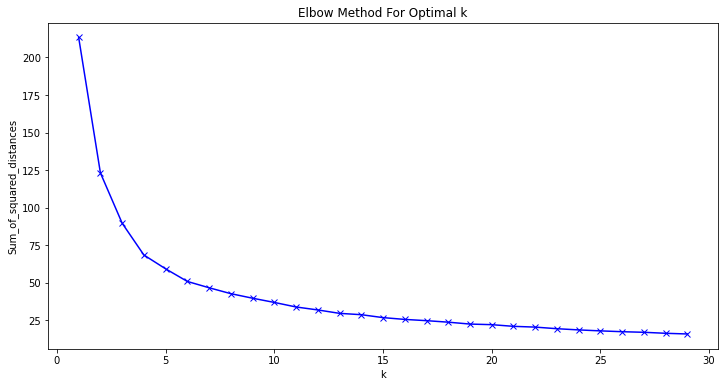

In [27]:
sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dim_reduction)
    sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [28]:
num_clusters = 6
kmeans = KMeans(num_clusters,init="k-means++", random_state=42)
clusters = kmeans.fit_predict(dim_reduction)

reduced_df['Cluster'] = clusters
reduced_df = reduced_df.reset_index(drop=True)

In [29]:
reduced_df['Segment K-means PCA'] = reduced_df['Cluster'].map({0:'robin',1:'player',2:'wingers',3:'giants',4:'superhero',5:'outsider'})
reduced_df.head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,BLK,TO,DD2,TD3,PER,PCA1,PCA2,PCA3,Cluster,Segment K-means PCA
0,Aaron Brooks,395.00,6.0,48.50,9.85,3.65,1.40,3.40,40.450001,0.50,...,0.05,0.65,0.00,0.00,9.74,-0.531466,-0.255569,0.000379,5,outsider
1,Aaron Gordon,85.67,4.0,64.33,31.18,14.60,5.50,12.07,45.900002,1.37,...,0.63,1.70,11.67,0.33,15.22,0.470477,0.130112,-0.092967,2,wingers
2,Aaron Holiday,244.50,1.0,57.50,17.92,7.25,2.68,6.42,41.950001,0.95,...,0.22,1.05,1.00,0.00,11.29,-0.171647,-0.242894,0.041093,0,robin
3,Aaron Nesmith,382.00,3.0,46.00,14.50,4.70,1.70,3.90,43.799999,0.90,...,0.20,0.50,0.00,0.00,9.46,-0.433517,-0.198849,-0.153901,5,outsider
4,Abdel Nader,352.50,3.0,47.00,13.22,5.00,1.78,4.05,42.950001,0.68,...,0.30,0.68,0.00,0.00,9.69,-0.432218,-0.160023,-0.109390,5,outsider


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


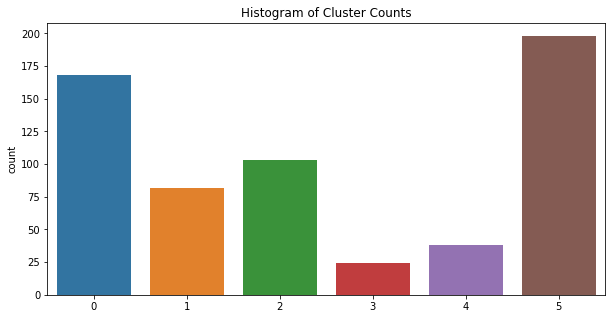

In [30]:
cluster_labels = kmeans.labels_
reduced_df['Cluster'] = cluster_labels

import seaborn as sns

ax=plt.subplots(figsize=(10,5))
ax=sns.countplot(cluster_labels)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [31]:
averages_df = reduced_df.groupby('Cluster').mean()
averages_df = averages_df.reset_index(drop=False)
averages_df = averages_df.apply(lambda x: round(x, 3))

In [32]:
df = averages_df[['PTS','FGM','FGA','FG%','3PM','3PA', '3P%', 'FTM','FTA','FT%','REB','AST','STL','BLK','DD2','TD3']]
df

,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,REB,AST,STL,BLK,DD2,TD3
0,9.075,3.307,7.692,42.945000,1.254,3.481,35.150002,1.208,1.535,78.179001,3.266,2.231,0.732,0.327,1.602,0.030
1,6.465,2.642,4.834,55.101002,0.114,0.398,13.944000,1.060,1.571,67.209999,4.814,0.985,0.458,0.687,3.825,0.011
2,14.630,5.347,12.058,44.300999,1.682,4.674,35.396000,2.250,2.801,79.734001,4.590,3.300,0.918,0.438,4.822,0.261
3,13.462,5.392,9.639,57.049999,0.260,0.818,19.403999,2.422,3.590,67.598999,9.153,1.974,0.747,1.219,23.708,0.539
4,23.028,8.160,17.263,47.286999,2.032,5.589,35.349998,4.686,5.779,81.189003,6.615,5.561,1.219,0.681,19.090,2.444
5,5.427,2.008,4.687,42.480999,0.675,1.998,32.394001,0.741,0.996,73.332001,2.497,1.321,0.505,0.254,0.478,0.005


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


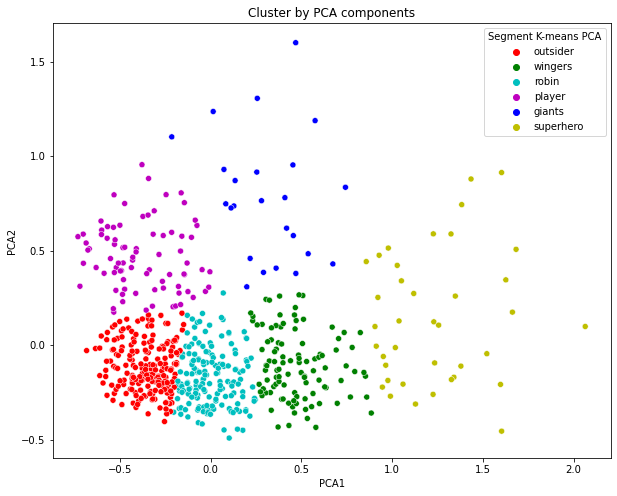

In [33]:
x_axis = reduced_df['PCA1']
y_axis = reduced_df['PCA2']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis, y_axis, hue=reduced_df['Segment K-means PCA'], palette=['r','g','c','m','b','y'])
plt.title('Cluster by PCA components')
plt.show()

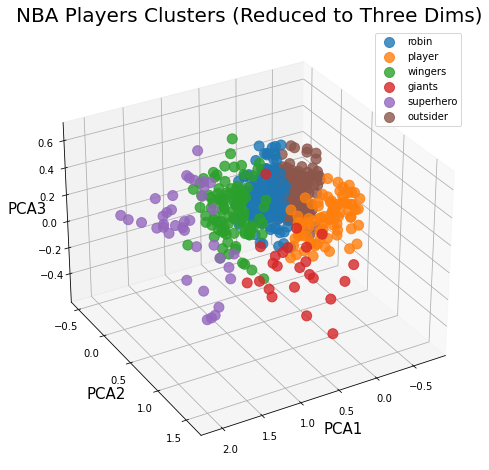

In [34]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(111, projection='3d')

ax.set_title('NBA Players Clusters (Reduced to Three Dims)', size=20)
ax.set_xlabel('PCA1', size=15)
ax.set_ylabel('PCA2', size=15)
ax.set_zlabel('PCA3', size=15)

handles = []

mapping = {0:'robin',1:'player',2:'wingers',3:'giants',4:'superhero',5:'outsider'}

for cluster in range(6):
    handles.append(cluster)
    tmp_df = reduced_df[reduced_df['Cluster'] == cluster]
    ax.scatter(tmp_df['PCA1'], tmp_df['PCA2'], tmp_df['PCA3'], label=mapping[cluster], s=100, alpha=0.8)

# ax.legend(cluster_and_player)
ax.view_init(30,60)
ax.grid()
ax.legend()
plt.show()

# Ciekawostki

In [35]:
from pyspark.sql.functions import mean
df = df_stats.groupBy("flag").agg(mean('3P%').alias('3P%_mean')).where(col('flag').like('Season%')).orderBy('flag').toPandas()
df.head()

,flag,3P%_mean
0,Season_Regular_2001_02,21.667352
1,Season_Regular_2002_03,21.561905
2,Season_Regular_2003_04,21.391324
3,Season_Regular_2004_05,22.028913
4,Season_Regular_2005_06,22.550885


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

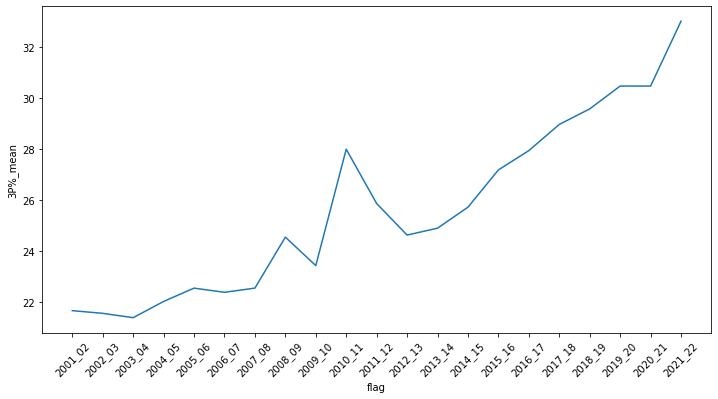

In [46]:
import matplotlib.pyplot as plt

df['flag'] = df['flag'].str[-7:]

sns.lineplot(df['flag'], df['3P%_mean'])
plt.xticks(rotation=45)

In [37]:
df_stats_sal = (
    spark.read
    .format("jdbc")
    .option("url", "jdbc:postgresql://postgres:5432/nba")
    .option("dbtable", "public.players_salaries")
    .option("user", "nba")
    .option("password", "nba")
    .option("driver", "org.postgresql.Driver")
    .load()
)
df_stats_sal.limit(10).toPandas().head(5)

,Rank,Player,salary,current_salary_inflation,flag
0,1.,Kobe Bryant,"$24,806,250","$30,921,289",2010/11
1,2.,Rashard Lewis,"$19,573,711","$24,398,866",2010/11
2,3.,Kevin Garnett,"$18,800,000","$23,434,426",2010/11
3,4.,Tim Duncan,"$18,700,000","$23,309,775",2010/11
4,5.,Michael Redd,"$18,300,000","$22,811,170",2010/11


In [38]:
df_salaries = df_stats_sal.toPandas()

df_salaries['salary'] = df_salaries['salary'].str[1:]
df_salaries['salary'] = df_salaries['salary'].str.split(',').str.join('').astype('int')

df_sal_grouped = df_salaries.groupby(by='flag').mean()
df_sal_grouped

,salary
flag,
2000/01,3.304929e+06
2003/04,3.684160e+06
2004/05,3.773688e+06
2005/06,3.961305e+06
2007/08,4.400601e+06
2009/10,4.633963e+06
2010/11,4.413547e+06
2013/14,4.305050e+06
2017/18,5.728105e+06


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 [Text(-2.0, 0, '2017/18'),
  Text(0.0, 0, '2000/01'),
  Text(2.0, 0, '2004/05'),
  Text(4.0, 0, '2007/08'),
  Text(6.0, 0, '2010/11'),
  Text(8.0, 0, '2017/18'),
  Text(10.0, 0, '')])

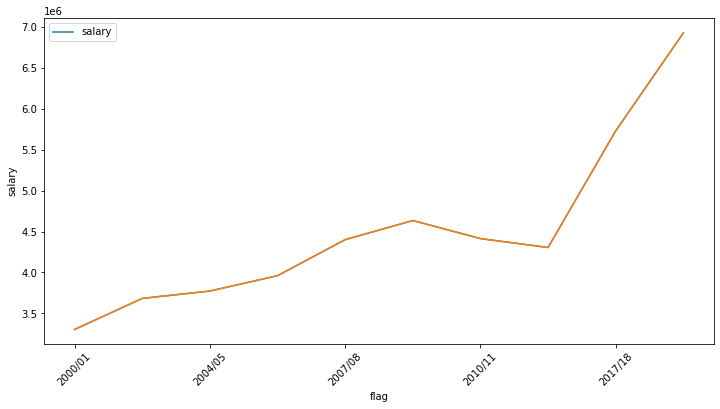

In [48]:
df_sal_grouped.plot()

sns.lineplot(df_sal_grouped.index, df_sal_grouped['salary'])
plt.xticks(rotation=45)

In [40]:
df_stats_inj = (
    spark.read
    .format("jdbc")
    .option("url", "jdbc:postgresql://postgres:5432/nba")
    .option("dbtable", "public.players_injuries")
    .option("user", "nba")
    .option("password", "nba")
    .option("driver", "org.postgresql.Driver")
    .load()
)
df_stats_inj = df_stats_inj.toPandas()
df_stats_inj.head()

,PLAYER,TEAM,INJURED ON,RETURNED,DAYS MISSED,flag
0,Christian Wood,Rockets,16 Feb 22,17 Feb 22,1,Illness
1,Terry Taylor,Pacers,11 Feb 22,12 Feb 22,1,Illness
2,Jonas Valanciunas,Pelicans,28 Jan 22,31 Jan 22,3,Illness
3,Will Barton,Nuggets,28 Jan 22,30 Jan 22,2,Illness
4,Day'Ron Sharpe,Nets,26 Jan 22,28 Jan 22,2,Illness


In [41]:
df_stats_inj['year_of_inj'] = df_stats_inj['INJURED ON'].str[-3:]
df_stats_inj_count = df_stats_inj.groupby(by='year_of_inj').count()
df_stats_inj_count.head()

,PLAYER,TEAM,INJURED ON,RETURNED,DAYS MISSED,flag
year_of_inj,,,,,,
11,20,20,20,20,20,20
12,26,26,26,26,26,26
13,48,48,48,48,48,48
14,62,62,62,62,62,62
15,162,162,162,162,162,162


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

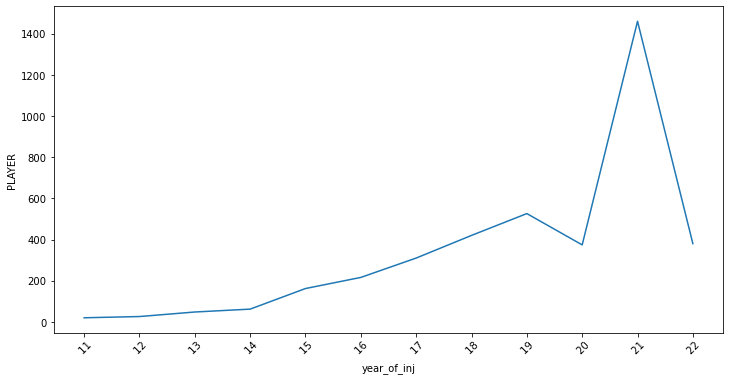

In [50]:


sns.lineplot(df_stats_inj_count.index, df_stats_inj_count['PLAYER'])
plt.xticks(rotation=45)